In [1]:
%matplotlib inline

# Librairies Matplotlib, NumPy et OpenCV
import matplotlib.pyplot as plt
import numpy as np
import cv2 #OpenCV
#
# optional
from sklearn.cluster import MiniBatchKMeans


In [2]:
images = [
    cv2.imread('./images/cameraman.tif', 0),
    cv2.imread('./images/spine.tif', 0),
    cv2.imread('./images/rice.tif', 0),
    cv2.imread('./images/Fire.jpg', 0),
    cv2.imread('./images/bar.png', 0),
]


In [3]:
def random_noise(image, coverage=0.1):
    image_copy = np.copy(image)

    for i in range(0, len(image)):
        for j in range(0, len(image[i])):
            if (np.random.rand() < coverage):
                image_copy[i][j] = np.random.choice([0, 255])

    return image_copy

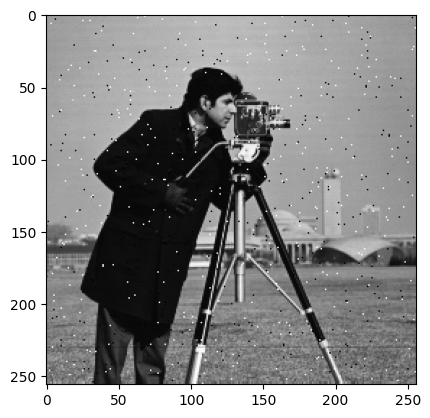

In [4]:
my_noised_image = random_noise(images[0], 0.01)


plt.imshow(my_noised_image, cmap='gray')

In [5]:
# Support functions 
'''imperative version'''

def select_sub_matrix(image, i, j, w, h, boxPointer_x=0, boxPointer_y=0):
    sub_matrix = []
    width, height = image.shape

    for x in range(0, h):
        calcI = i + x - boxPointer_x
        
        hasRow = calcI <= height - 1 - boxPointer_x

        sub_matrix.append([])

        for y in range(0, w):
            calcJ = j + y - boxPointer_y
            hasCol = calcJ <= width - 1 - boxPointer_y

            if (hasRow and hasCol and (calcI >= 0 and calcJ >= 0)):
                sub_matrix[x].append(image[calcI][calcJ])
            else: # what about borders?
                sub_matrix[x].append(0)

    return sub_matrix


# maps and applies function to each of sub matrices of matrix (returns new matrix)
def map_matrix_parts(image)->np.ndarray:

    def _map_matrix_parts(fn, sub_w, sub_h, padding=1, boxPointer_x=0, boxPointer_y=0):
        image_copy = np.copy(image)

        for i in range(0, len(image) - 1, padding):
            for j in range(0, len(image[i]) - 1, padding):
                sub_matrix = select_sub_matrix(image, i, j, sub_w, sub_h, boxPointer_x, boxPointer_y)

                image_copy[i][j] = fn(sub_matrix)

        return image_copy

    return _map_matrix_parts


def binary_same_matrix(matrix1, matrix2):
    for i in range(0, len(matrix1)):
        for j in range(0, len(matrix1[i])):
            if bool(matrix1[i][j]) != bool(matrix2[i][j]):
                return False

    return True

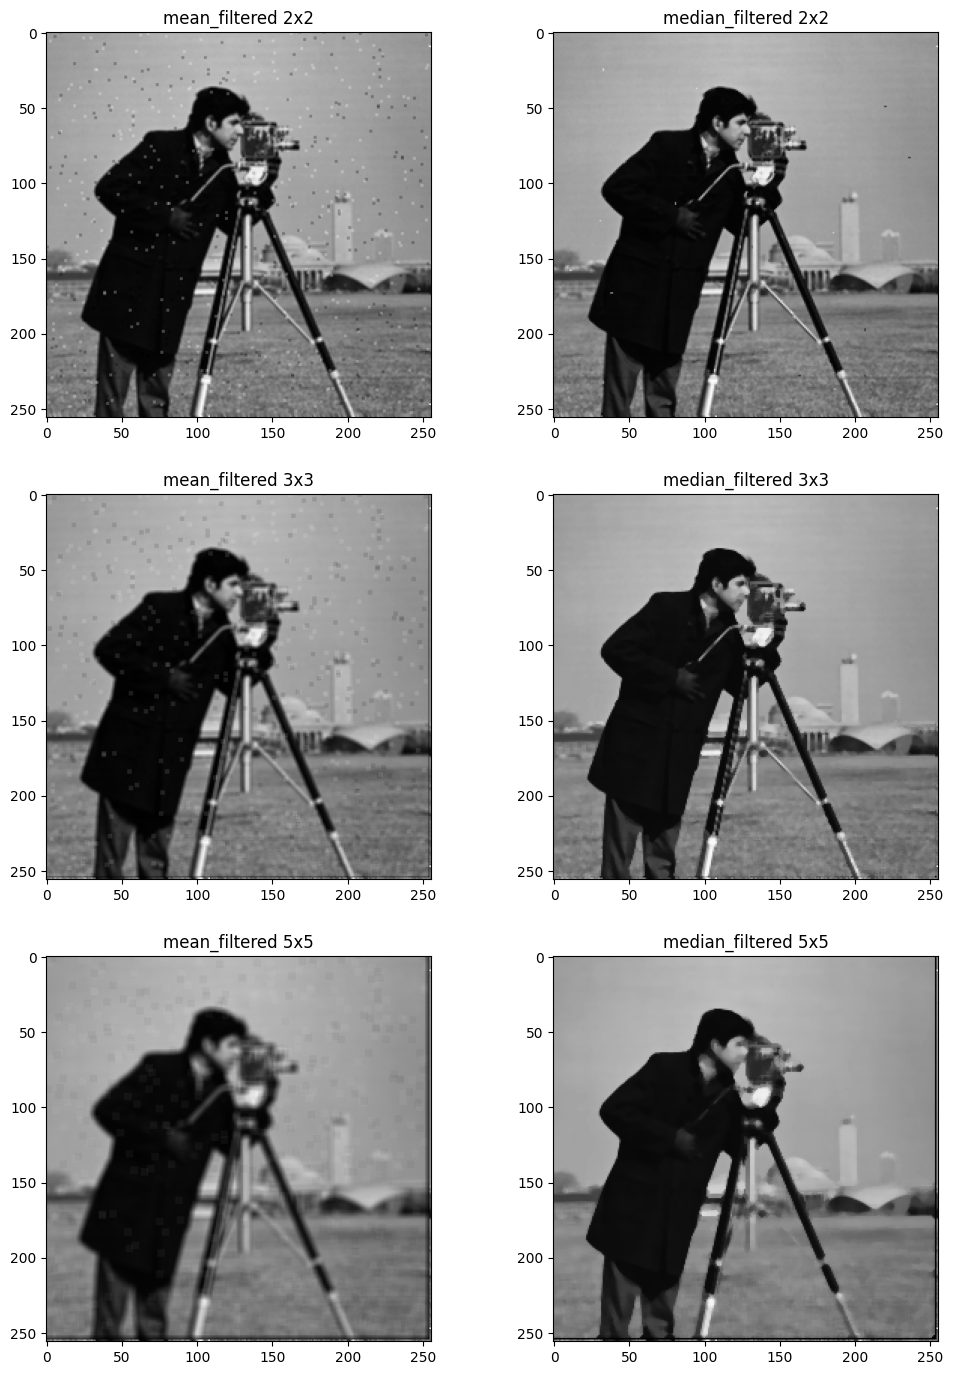

In [6]:
image_tomap = map_matrix_parts(my_noised_image)

mean_filtered_2 = image_tomap(np.mean, 2, 2)
median_filtered_2 = image_tomap(np.median, 2, 2)

mean_filtered_3 = image_tomap(np.mean, 3, 3)
median_filtered_3 = image_tomap(np.median, 3, 3)

mean_filtered_5 = image_tomap(np.mean, 5, 5)
median_filtered_5 = image_tomap(np.median, 5, 5)

fig = plt.figure(figsize=(12, 17));

rows = 3;
columns = 2;

fig.add_subplot(rows, columns, 1)
plt.title("mean_filtered 2x2")
plt.imshow(mean_filtered_2, cmap='gray')

fig.add_subplot(rows, columns, 2)
plt.title("median_filtered 2x2")
plt.imshow(median_filtered_2, cmap='gray')

fig.add_subplot(rows, columns, 3)
plt.title("mean_filtered 3x3")
plt.imshow(mean_filtered_3, cmap='gray')

fig.add_subplot(rows, columns, 4)
plt.title("median_filtered 3x3")
plt.imshow(median_filtered_3, cmap='gray')


fig.add_subplot(rows, columns, 5)
plt.title("mean_filtered 5x5")
plt.imshow(mean_filtered_5, cmap='gray')

fig.add_subplot(rows, columns, 6)
plt.title("median_filtered 5x5")
plt.imshow(median_filtered_5, cmap='gray')



so the mean filter will work much better as it will ignore the sharp lows and highs of the shades 

I notised that: we filter our noise better but lose details with increasing size of mean filter.

With increasing size of median filter we lose shades but keep details

# Using readymade functions:

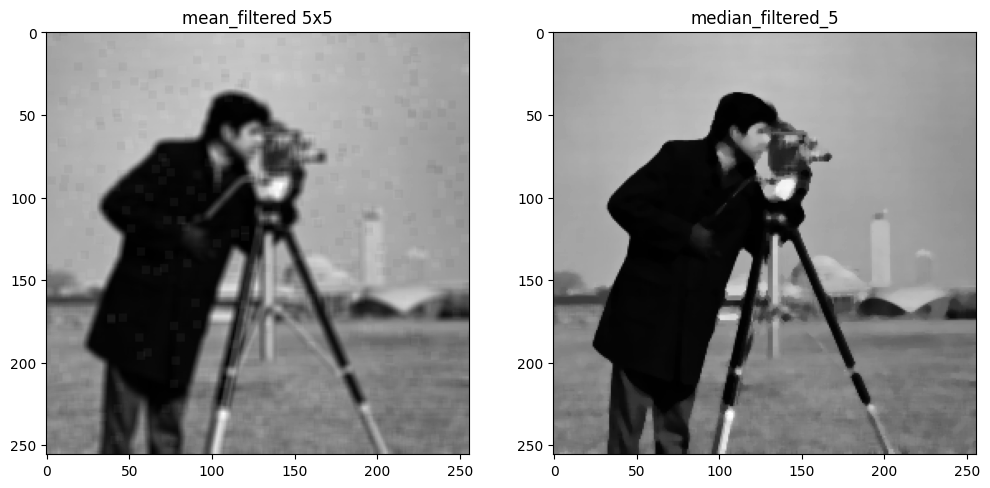

In [7]:
kernal_size = 5

kernel = np.ones((kernal_size, kernal_size), np.float32) / kernal_size**2


mean_filtered_5 = cv2.filter2D(my_noised_image, -1, kernel)
median_filtered_5 = cv2.medianBlur(my_noised_image, 5)


fig = plt.figure(figsize=(12, 17))

rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.title("mean_filtered 5x5")
plt.imshow(mean_filtered_5, cmap='gray')

fig.add_subplot(rows, columns, 2)
plt.title("median_filtered_5")
plt.imshow(median_filtered_5, cmap='gray')


# Gaussian filtering

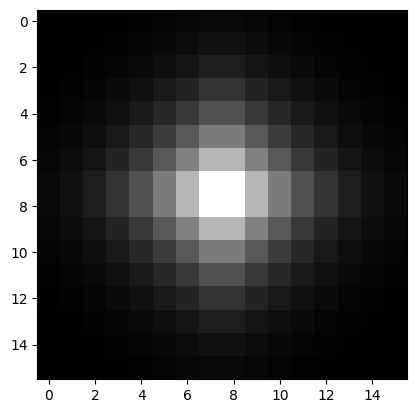

In [12]:
def gause(x, y, sigma):
    return np.exp(-((x**2 + y**2) / (2 * sigma**2)))

def get_gause_kernal(sigma, size):
    kernal = np.zeros((size, size))

    pad = size // 2

    for i in range(0, size):
        for j in range(0, size):
            kernal[i][j] = gause(i, j, sigma)

    kernal /= np.sum(kernal)


    # mirrioring...
    for i in range(0, pad):
        for j in range(pad, size):
            kernal[i][j] = kernal[size - i - 1][j]

    for i in range(0, pad):
        for j in range(0, pad):
            kernal[i][j] = kernal[size - i - 1][size - j - 1]


    for i in range(pad, size):
        for j in range(0, pad):
            kernal[i][j] = kernal[i][size - j - 1]

    return kernal


size = 16
sigma = 5

gause_kernal = get_gause_kernal(sigma, size)
plt.imshow(gause_kernal, cmap='gray')



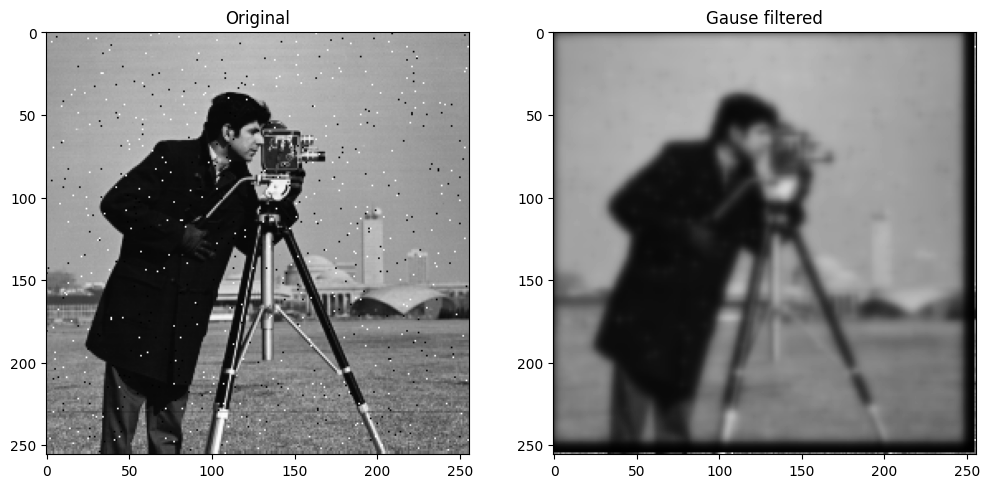

In [9]:
image_tomap = map_matrix_parts(my_noised_image)


def apply_gause_filter(matrix):

    return np.sum(matrix * gause_kernal) / np.sum(gause_kernal)


gause_filtered = image_tomap(apply_gause_filter, size, size, boxPointer_x=size // 2, boxPointer_y=size // 2)

fig = plt.figure(figsize=(12, 17))

rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.title("Original")
plt.imshow(my_noised_image, cmap='gray')

fig.add_subplot(rows, columns, 2)
plt.title("Gause filtered")
plt.imshow(gause_filtered, cmap='gray')
    

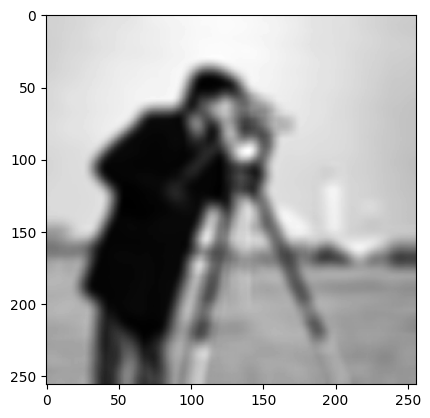

In [14]:
gause = cv2.GaussianBlur(images[0], (15,15), sigmaX =5, sigmaY=5)

plt.imshow(gause, cmap='gray')

# Morphological operations

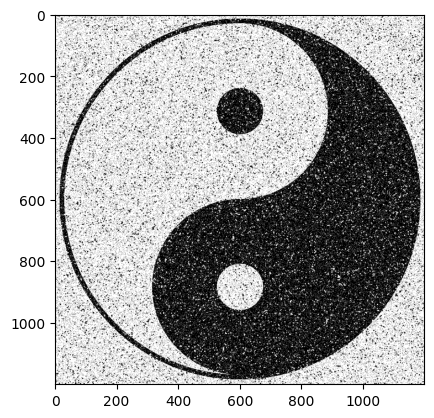

In [16]:
noisy_yin_yang = cv2.imread('./images/noisy_yin_yang.png', -1)
plt.imshow(noisy_yin_yang, cmap='gray')

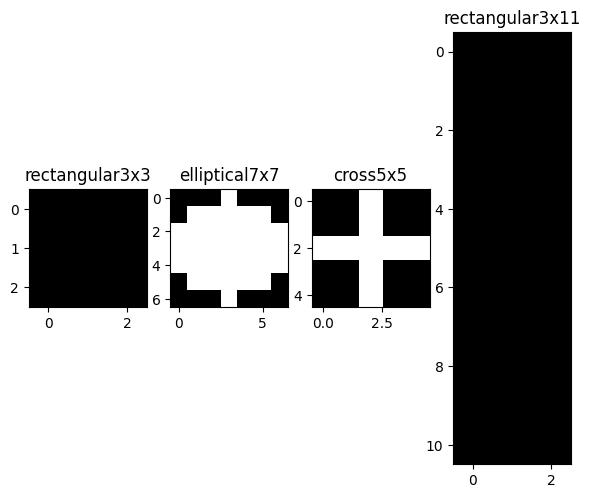

In [17]:
# Code here
# Construction and plot of kernels

kernels = {
    "rectangular3x3": cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)),
    "elliptical7x7": cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)),
    "cross5x5": cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)),
    "rectangular3x11": cv2.getStructuringElement(cv2.MORPH_RECT,(3,11))
}
# структурный элемент

rows = 1;
columns = kernels.__len__();

fig = plt.figure(figsize=(7, 7))

for i, (name, kernel) in enumerate(kernels.items()):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(kernel, cmap='gray')
    plt.title(name)


# Erosion 
$ {\epsilon}_K(I) = \{ x|K_{x} \subset I \}$

In [18]:
# Code here
# Implementation of erosion function
def errosion(matrix, kernel):
    k_w, k_h = kernel.shape
    
    mult = matrix * kernel

    if (binary_same_matrix(mult, kernel)):
        return 255

    return 0

def apply_erosion(image, kernel):
    k_w, k_h = kernel.shape
    
    return map_matrix_parts(image)(lambda sub_mat: errosion(sub_mat, kernel), k_w, k_h, 1, k_w//2, k_h//2)

# example 
kernal = kernels['cross5x5']

mat_cross = np.array([
    [ 0,   0,  255,  0,   0],
    [ 0,   0,  255,  0,   0],
    [255, 255, 255, 255, 255],
    [ 0,   0,  255,  0,   0],
    [ 0,   0,  255,  0,   0],
])

errosion(mat_cross, kernels['cross5x5'])

255

Text(0.5, 1.0, 'erroised')

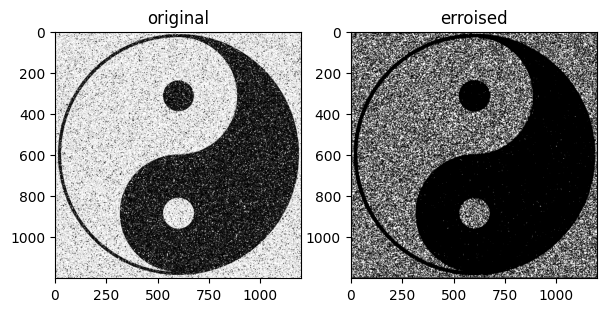

In [19]:
# Code here
# Application of the function on image and showing result 
original = noisy_yin_yang
erroised = apply_erosion(original, kernels['cross5x5'])

rows = 1
columns = 2

fig = plt.figure(figsize=(7, 7))

fig.add_subplot(rows, columns, 1)
plt.imshow(original, cmap='gray')
plt.title('original')

fig.add_subplot(rows, columns, 2)
plt.imshow(erroised, cmap='gray')
plt.title('erroised')




In [ ]:
# comparig with cv2.erode

erosian = cv2.erode(noisy_yin_yang, kernels['cross5x5'])
plt.figure(figsize=(3, 3))
plt.imshow(erosian, cmap='gray')

# Dilatation
$ {\delta}_K(I) = \{ x|K_{x} \cap I \neq \emptyset \}$

In [20]:
# Code here
# Implementation of dilatation function
def dilatation(matrix, kernel):
    k_w, k_h = kernel.shape
    
    mult = matrix * kernel

    if (mult.any()):
        return 255

    return 0

def apply_dilatation(image, kernel):
    k_w, k_h = kernel.shape
    
    return map_matrix_parts(image)(lambda sub_mat: dilatation(sub_mat, kernel), k_w, k_h, 1, k_w//2, k_h//2)

# example

mat_cross = np.array([
    [ 0,   0,  0,  0,   0],
    [ 0,   0,  0,  0,   0],
    [ 0,   0, 255, 0,   0],
    [ 0,   0,  0,  0,   0],
    [ 0,   0,  0,  0,   0],
])

dilatation(mat_cross, kernels['cross5x5'])

255

Text(0.5, 1.0, 'dilated')

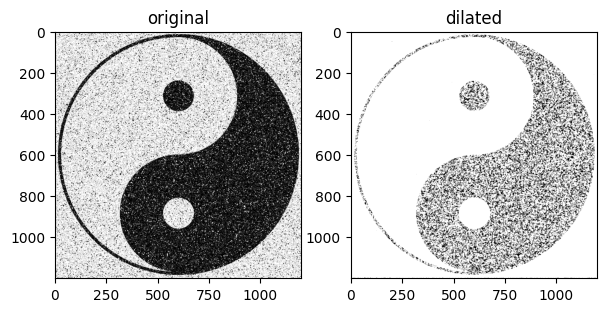

In [21]:
# Code here
# Application of dilatation on the image and show the result
original = noisy_yin_yang
dilated = apply_dilatation(original, kernels['cross5x5'])

rows = 1
columns = 2

fig = plt.figure(figsize=(7, 7))

fig.add_subplot(rows, columns, 1)
plt.imshow(original, cmap='gray')
plt.title('original')

fig.add_subplot(rows, columns, 2)
plt.imshow(dilated, cmap='gray')
plt.title('dilated')


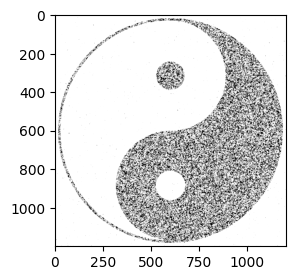

In [22]:
# comparig with cv2.dilate

dilatian = cv2.dilate(noisy_yin_yang, kernels['cross5x5'])
plt.figure(figsize=(3, 3))
plt.imshow(dilatian, cmap='gray')

# Erosion then a dilation

Text(0.5, 1.0, 'errosion dilation')

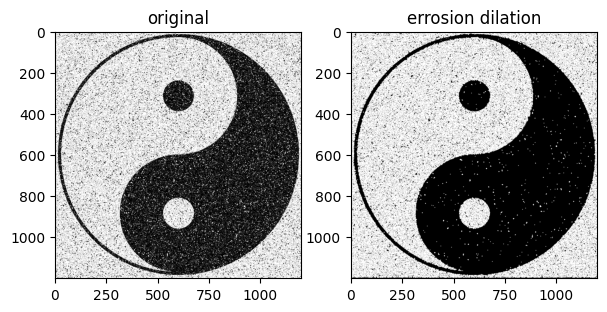

In [23]:
def dilatation_erroision(image, kernel):
    return apply_dilatation(apply_erosion(image, kernel), kernel)

original = noisy_yin_yang
processed = dilatation_erroision(original, kernels['cross5x5'])


rows = 1
columns = 2

fig = plt.figure(figsize=(7, 7))

fig.add_subplot(rows, columns, 1)
plt.imshow(original, cmap='gray')
plt.title('original')

fig.add_subplot(rows, columns, 2)
plt.imshow(processed, cmap='gray')
plt.title('errosion dilation')

# Dilatation - Erosion

Text(0.5, 1.0, 'gradient yin_yang')

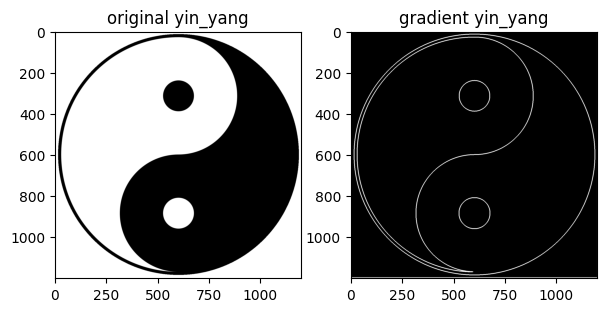

In [25]:
def apply_gradient(image, kernel):
    return apply_dilatation(image, kernel) - apply_erosion(image, kernel)


original = cv2.imread('./images/yin_yang.png', -1)
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
processed = apply_gradient(original, kernels['cross5x5'])

rows = 1
columns = 2

fig = plt.figure(figsize=(7, 7))

fig.add_subplot(rows, columns, 1)
plt.imshow(original, cmap='gray')
plt.title('original yin_yang')

fig.add_subplot(rows, columns, 2)
plt.imshow(processed, cmap='gray')
plt.title('gradient yin_yang')
